<a href="https://colab.research.google.com/github/SimonGiebenhain/ma_proj/blob/master/Kopie_von_GON.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# requirements
import torch
import torch.nn as nn
import torchvision
import numpy as np

# colab requirements
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep

In [2]:
# image data
dataset_name = 'mnist' # ['mnist', 'fashion']
img_size = 28
n_channels = 1
img_coords = 2

# training info
lr = 1e-4
batch_size = 64
sample_size = 256
num_latent = 10
num_latent_adv = 5
hidden_features = 128
num_layers = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# create the GON network (a SIREN as in https://vsitzmann.github.io/siren/)
class SirenLayer(nn.Module):
    def __init__(self, in_f, out_f, w0=30, is_first=False, is_last=False):
        super().__init__()
        self.in_f = in_f
        self.w0 = w0
        self.linear = nn.Linear(in_f, out_f)
        self.is_first = is_first
        self.is_last = is_last
        self.init_weights()
    
    def init_weights(self):
        b = 1 / self.in_f if self.is_first else np.sqrt(6 / self.in_f) / self.w0
        with torch.no_grad():
            self.linear.weight.uniform_(-b, b)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.sin(self.w0 * x)

class MLPLayer(nn.Module):
    def __init__(self, in_f, out_f, is_last):
        super().__init__()
        self.in_f = in_f
        self.is_last = is_last
        self.linear = nn.Linear(in_f, out_f)

    def forward(self, x):
        x = self.linear(x)
        return x if self.is_last else torch.nn.functional.relu(x)


def gon_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers.append(SirenLayer(dim0, dim1))
    final_layer = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(first_layer, *other_layers, final_layer)

def simple_model(dimensions):
    other_layers = []
    for dim0, dim1 in zip(dimensions[0:-2], dimensions[1:-1]):
        other_layers.append(MLPLayer(dim0, dim1, is_last=False))
    final_layer = MLPLayer(dimensions[-2], dimensions[-1], is_last=True)
    return nn.Sequential(*other_layers, final_layer)

def ging_model(dimensions):
    first_layer = SirenLayer(dimensions[0], dimensions[1], is_first=True)
    other_layers_trainee = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers_trainee.append(SirenLayer(dim0, dim1))
    other_layers_trainer = []
    for dim0, dim1 in zip(dimensions[1:-2], dimensions[2:-1]):
        other_layers_trainer.append(SirenLayer(dim0, dim1))
    final_layer_trainee = SirenLayer(dimensions[-2], dimensions[-1], is_last=True)
    final_layer_trainer = SirenLayer(dimensions[-2], 6, is_last=True)
    return nn.Sequential(first_layer, *other_layers_trainee, final_layer_trainee), nn.Sequential(first_layer, *other_layers_trainer, final_layer_trainer)

In [4]:
# helper functions
def get_mgrid(sidelen, dim=2):
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def slerp(a, b, t):
    omega = torch.acos((a/torch.norm(a, dim=1, keepdim=True)*b/torch.norm(b, dim=1, keepdim=True)).sum(1)).unsqueeze(1)
    res = (torch.sin((1.0-t)*omega)/torch.sin(omega))*a + (torch.sin(t*omega)/torch.sin(omega)) * b
    return res

def slerp_batch(model, z, coords):
    lz = z.data.clone().squeeze(1)
    col_size = int(np.sqrt(z.size(0)))
    src_z = lz.data[:col_size].repeat(col_size,1)
    z1, z2 = lz.data.split(lz.shape[0]//2)
    tgt_z = torch.cat([z2, z1])
    tgt_z = tgt_z[:col_size].repeat(col_size,1)
    t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).contiguous().view(batch_size,1).contiguous().to(device)
    z_slerp = slerp(src_z, tgt_z, t)
    z_slerp_rep = z_slerp.unsqueeze(1).repeat(1,coords.size(1),1) 
    g_slerp = model(torch.cat((coords, z_slerp_rep), dim=-1))
    return g_slerp

def gon_sample(model, recent_zs, coords):
    zs = torch.cat(recent_zs, dim=0).squeeze(1).cpu().numpy()
    mean = np.mean(zs, axis=0)
    cov = np.cov(zs.T)
    sample = np.random.multivariate_normal(mean, cov, size=batch_size)
    sample = torch.tensor(sample).unsqueeze(1).repeat(1,coords.size(1),1).to(device).float()
    model_input = torch.cat((coords, sample), dim=-1)
    return model(model_input)

# This function returns the indices of bounding boxes of radius 'radius' around 
# the sampled locations 'loc_samps'.
# @Arguments:
#   - loc_samps: tensor of dimensions [batch_size, sample_size, dim]
#   - radius: radius of window around sampled location
#   - img_size: size of complete image
# @Returns:
#   - windos: window indices of dimensions [batch_size, sample_size, (2*radius+1)^dim, dim], 
#   where the size of the second to last dimension might be smaller, if the window
#   would reach outside of the image otherwise.
#   - ds: distances of sampled location to every point in the window
def get_windows(loc_samps, radius, img_size):
  batch_size = loc_samps.shape[0]
  sample_size = loc_samps.shape[1]
  dims = loc_samps.shape[2]

  #compute indices
  scaled_samps = (loc_samps+1)/2*(img_size-1)
  centers = torch.round(scaled_samps).long()
  grid_x, grid_y = torch.meshgrid(torch.arange(-radius, radius+1, device=device, dtype=torch.long), torch.arange(-radius, radius+1, device=device, dtype=torch.long))
  grid = torch.stack([grid_x, grid_y], dim=2)
  windows = grid.view(1, 1, -1, dims) + centers.view(batch_size, sample_size, 1, dims)
  valid_locs = torch.logical_and(windows <= img_size - 1, windows >= 0)
  valid_windows = windows[valid_locs].view(batch_size, sample_size, -1, dims)
  
  #compute distances
  ds = torch.sqrt(torch.sum((scaled_samps.view(batch_size, sample_size, 1, dims) - valid_windows)**2, dim=3))

  #compute weights
  w = torch.where(valid_locs.all(3), torch.softmax(-2*ds, dim=2), torch.zeros(1, device=device))
  #w = torch.zeros([batch_size, sample_size, windows.shape[2]]).to(device)
  #w[valid_locs.all(3)] = 
  ##invalid locations get wieght 0
  #w[(~valid_locs).any(3)] = 0

  #invalid locations get assigned index 0 in order to prevent indexing error
  windows[~valid_locs] = 0

  return windows, w

def linearize_idx(idx, img_size):
  dims = idx.shape[-1]
  lin_idx = torch.zeros(idx.shape[:-1], dtype=torch.long).to(device)
  for d in range(dims):
    lin_idx += idx[:, :, :, d] * img_size**(dims-1-d)
  return lin_idx


In [5]:
# TEST: linearize_idx()
#xx, yy, zz = torch.meshgrid(torch.arange(2), torch.arange(2), torch.arange(2))
#print(xx)
#idx = torch.stack([xx, yy, zz], dim=3)
#print(idx)
#print(idx.shape)
#I = torch.arange(8).view(2,2,2)
#print(I)
#print(I.view(-1))
#idx = idx.view(8,3)
#print(idx)
##print(idx[:, 0]*3**0)
##print(idx[:, 1]*3**1)
##print(idx[:, 0]*3**0 + idx[:, 1]*3**1)
#linearize_idx(idx.view(1, 1, 8, 3), 2)


In [6]:
from torch.utils.data import Dataset, DataLoader

class IdxedDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        
    def __getitem__(self, index):
        data, target = self.dataset[index]    
        return data, target, index

    def __len__(self):
        return len(self.dataset)

In [7]:
# load datasets
if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]))
if dataset_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ]))
print(dataset)
dataset = IdxedDataset(dataset)
#loader = DataLoader(dataset,
#                    batch_size=1,
#                    shuffle=True,
#                    num_workers=1)

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [8]:
# define GON architecture, for example gon_shape = [34, 256, 256, 256, 256, 1]
gon_shape = [img_coords+num_latent] + [hidden_features]*num_layers + [n_channels]
num_noise = 2
adv_shape = [num_latent] + [hidden_features]*3 + [img_coords]
F = gon_model(gon_shape).to(device)
adv = gon_model(adv_shape).to(device)

optim_main = torch.optim.Adam(lr=lr, params=F.parameters())
optim_main_fine = torch.optim.Adam(lr=lr, params=F.parameters())

optim_adv = torch.optim.Adam(lr=lr, params=adv.parameters())

c = torch.stack([get_mgrid(img_size, 2) for _ in range(batch_size)]).to(device) # coordinates

print(c.shape)
print(c)
recent_zs = []
print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(F.parameters()))}')

torch.Size([64, 784, 2])
tensor([[[-1.0000, -1.0000],
         [-1.0000, -0.9259],
         [-1.0000, -0.8519],
         ...,
         [ 1.0000,  0.8519],
         [ 1.0000,  0.9259],
         [ 1.0000,  1.0000]],

        [[-1.0000, -1.0000],
         [-1.0000, -0.9259],
         [-1.0000, -0.8519],
         ...,
         [ 1.0000,  0.8519],
         [ 1.0000,  0.9259],
         [ 1.0000,  1.0000]],

        [[-1.0000, -1.0000],
         [-1.0000, -0.9259],
         [-1.0000, -0.8519],
         ...,
         [ 1.0000,  0.8519],
         [ 1.0000,  0.9259],
         [ 1.0000,  1.0000]],

        ...,

        [[-1.0000, -1.0000],
         [-1.0000, -0.9259],
         [-1.0000, -0.8519],
         ...,
         [ 1.0000,  0.8519],
         [ 1.0000,  0.9259],
         [ 1.0000,  1.0000]],

        [[-1.0000, -1.0000],
         [-1.0000, -0.9259],
         [-1.0000, -0.8519],
         ...,
         [ 1.0000,  0.8519],
         [ 1.0000,  0.9259],
         [ 1.0000,  1.0000]],

        [[-

sampled loss:106.39706420898438
sampled loss:49.75732421875
sampled loss:41.33220672607422
sampled loss:37.599395751953125
sampled loss:33.850242614746094
sampled loss:31.137237548828125
Step: 100   Loss: 31.137


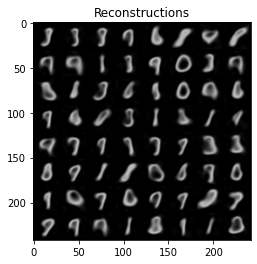

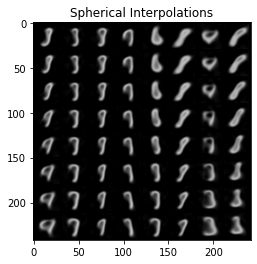

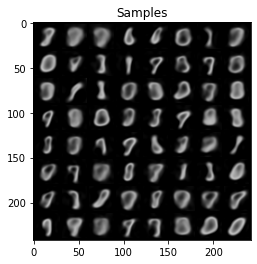

sampled loss:30.705463409423828
sampled loss:28.746353149414062
sampled loss:27.09070587158203
sampled loss:26.210247039794922
sampled loss:23.83822250366211
Step: 200   Loss: 23.838


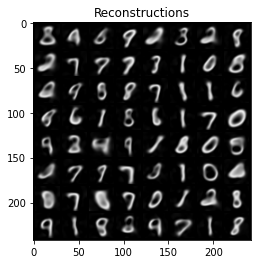

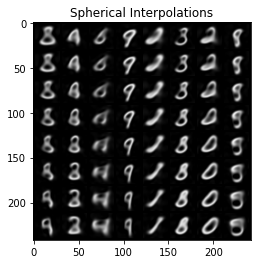

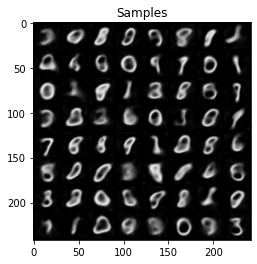

sampled loss:21.920822143554688
sampled loss:25.89862060546875
sampled loss:25.107553482055664
sampled loss:22.07755470275879
sampled loss:22.470603942871094
Step: 300   Loss: 22.471


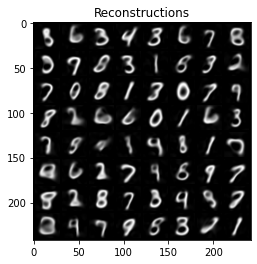

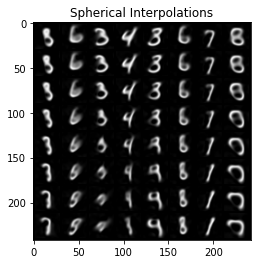

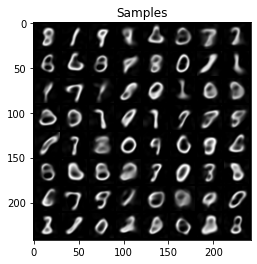

sampled loss:20.838653564453125
sampled loss:18.98269271850586
sampled loss:23.74127197265625
sampled loss:19.268957138061523
sampled loss:20.692581176757812
Step: 400   Loss: 20.693


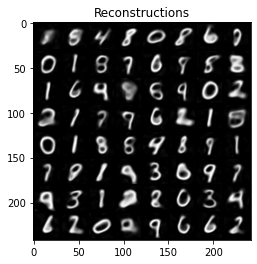

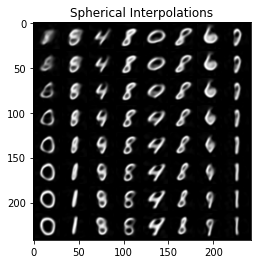

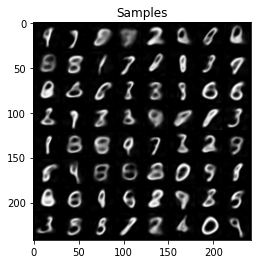

sampled loss:21.270355224609375
sampled loss:19.17028045654297
sampled loss:19.699657440185547
sampled loss:19.18289566040039
sampled loss:20.479721069335938
Step: 500   Loss: 20.480


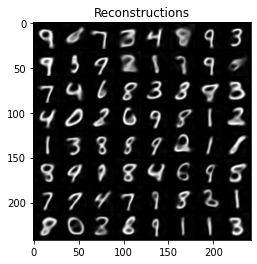

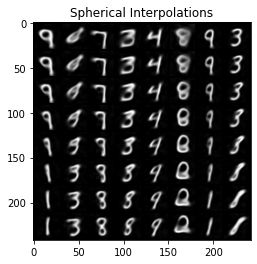

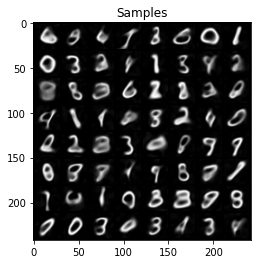

In [9]:
#z = torch.randn(dataset.__len__(), num_latent).to(device) #torch.zeros(dataset.__len__(), num_latent).to(device)
#z.requires_grad_(True)
#optim_latent = torch.optim.Adam(params=[z], lr=1e-3)
#for ep in range(50):
#  print('EPOCH: {}'.format(ep))
#  for step, (x, t, idx) in enumerate(train_loader):
for step in range(501):
    # sample a batch of data
    x, t, idx = next(train_iterator)
    x, t, idx = x.to(device), t.to(device), idx.to(device)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(batch_size, -1, n_channels)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep_main = z.repeat(1,c.size(1),1)
    g = F(torch.cat((c, z_rep_main), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z_main = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
    z_rep_main = z_main.repeat(1, c.size(1), 1)
    #z_rep = z[idx, :]
    #z_main = z_rep.unsqueeze(1)
    #z_rep_main = z_main.repeat(1, c.size(1), 1)
    
    
    
    #z_rep_adv = z_main.repeat(1, sample_size, 1).detach().clone()

    #g = F(torch.cat((c, z_rep_main), dim=-1))
    #L_outer = ((g - x)**2).sum(1).mean()
    #print('normal loss:{}'.format(L_outer.data))
    #optim_main.zero_grad()
    #L_outer.backward()
    #optim_main.step()


    #noise = torch.from_numpy(np.random.normal(0, 1, [batch_size, sample_size, num_noise])).float().to(device)
    #samps = torch.sigmoid(adv(torch.cat([noise, z_rep_adv], dim=-1)))
    #samps_discr = torch.round(samps * img_size).long()
    #samps_discr = samps_discr[:, :, 0]*img_size + samps_discr[:, :, 1]
    #if step % 10 == 0:
    #  print(samps_discr)

    # now with z as our new latent points, optimise the data fitting loss
    g = F(torch.cat((c, z_rep_main), dim=-1))
    L_outer = ((g - x)**2).sum(1).mean()
    #L_outer = ((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr, :])**2).mean(1).mean()
    if step % 20 == 0:
      print('sampled loss:{}'.format(L_outer.data))
    #optim_adv.zero_grad()
    optim_main.zero_grad()
    #optim_latent.zero_grad()
    L_outer.backward()
    #for p in adv.parameters():
    #  if p.grad is not None: 
    #   p.grad.data.mul_(-1) 
    #optim_adv.step()
    optim_main.step()
    #optim_latent.step()




    # compute sampling statistics
    recent_zs.append(z_main.detach())
    recent_zs = recent_zs[-100:]

    if step % 100 == 0 and step > 0:
        print(f"Step: {step}   Loss: {L_outer.item():.3f}")
        z_rep = z_main.repeat(1, c.shape[1], 1)
        g = F(torch.cat((c, z_rep), dim=-1))
        # plot reconstructions, interpolations, and samples
        recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z_main.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        sample = torchvision.utils.make_grid(torch.clamp(gon_sample(F, recent_zs, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size))

        plt.title('Reconstructions')
        plt.imshow(recons[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Spherical Interpolations')
        plt.imshow(slerps[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Samples')
        plt.imshow(sample[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.show()
        sleep(1)

In [17]:
num_latent_adv = 3
num_noise = 2

adv_shape = [num_latent + num_noise] + [64]*4 + [img_coords]
adv = gon_model(adv_shape).to(device)
optim_adv = torch.optim.Adam(lr=1e-5, params=adv.parameters())


In [20]:
sample_size = 2
batch_size=64

In [12]:
direct_idx = torch.zeros(batch_size, sample_size, 2).to(device)#torch.FloatTensor(batch_size, sample_size, 2).uniform_(-1, 1).to(device)#
direct_idx.requires_grad_(True)
optim_direct = torch.optim.Adam([direct_idx], lr=1e-3)
#ZADV = torch.zeros(batch_size, sample_size, num_latent_adv).to(device)
#ZADV.requires_grad_(True)
#optim_latent = torch.optim.Adam([ZADV], lr= 1e-4)



In [21]:
OPT_STEPS = 2500
locs = np.zeros([OPT_STEPS, batch_size, sample_size, 2])
for step in range(OPT_STEPS):
    # sample a batch of data
    x, t, idx = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(batch_size, -1, n_channels)

    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep_main = z.repeat(1,c.size(1),1)
    g = F(torch.cat((c, z_rep_main), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z_main = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
    z_rep_main = z_main.repeat(1, sample_size, 1)

    #z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    #z_adv = z.repeat(1, sample_size, 1)
    #samps_inner = torch.tanh(adv(z_adv))
    #samps_discr_inner = torch.floor((samps_inner+1)/2 * img_size).long().detach()
    #samps_discr_inner = samps_discr_inner[:, :, 0]*img_size + samps_discr_inner[:, :, 1]
    #g = F(torch.cat((samps_inner, z_rep_main), dim=-1))
    #L_adv_inner = ((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr_inner, :])**2).sum(1).mean()
    #z_adv = -torch.autograd.grad(L_adv_inner, [z], create_graph=True, retain_graph=True)[0]
    #z_rep_adv = z_adv.repeat(1, sample_size, 1)
    #z_rep_adv = ZADV.repeat(1, sample_size, 1)

    #g = F(torch.cat((c, z_rep_main), dim=-1))
    #L_outer = ((g - x)**2).sum(1).mean()
    #print('normal loss:{}'.format(L_outer.data))
    #optim_main.zero_grad()
    #L_outer.backward()
    #optim_main.step()


    noise1 = torch.from_numpy(np.random.normal(0, 1, [batch_size, sample_size, num_noise])).float().to(device)
    samps1 = torch.tanh(adv(torch.cat([noise1, z_rep_main], dim=2)))
    #samps1 = torch.tanh(adv(z_rep_main))

    #samps1 = torch.FloatTensor(batch_size, sample_size,2).uniform_(-1, 1).to(device) #direct_idx
    #samps1 = direct_idx
    locs[step, :, :, :] = samps1.detach().cpu().data


    windows, w = get_windows(samps1, 2, img_size)

    # linearize window index, should have shape [batch_size x sample_size * window_size]
    win_lin = linearize_idx(windows, img_size).view(batch_size, -1)
    x_cropped = x[torch.arange(batch_size).unsqueeze(1), win_lin, :].view(batch_size, sample_size, -1)
    target = torch.matmul(w.view(batch_size, sample_size, 1, -1), x_cropped.view(batch_size, sample_size, -1, 1))

    #ds = torch.sqrt(((c - samps1.repeat(1, 784, 1))**2).sum(2))
    #w = torch.softmax(-50*ds, dim=1)
    ##print(torch.topk(w, 5, dim=1))
    #target = torch.bmm(w.view(batch_size, 1, 784), x.view(batch_size, 784, 1))



    mesh_size = 3
    #TODO get x and y range for the meshgrid: what to do for boundary cases
    # produce meshgrid, stack meshes, get distances, weights and targets as before
    
    #samps_ceil = torch.ceil(((samps1.clamp(-1,1)+1)/2)*(img_size-1)).detach()
    #samps_floor = torch.floor(((samps1.clamp(-1,1)+1)/2)*(img_size-1)).detach()
    #xl = samps_floor[:, :, 0]
    #xu = samps_ceil[:, :, 0]
    #yl = samps_floor[:, :, 1]
    #yu = samps_ceil[:, :, 1]

    #p1 = torch.stack([xl, yl], 2)
    #p2 = torch.stack([xu, yl], 2)
    #p3 = torch.stack([xl, yu], 2)
    #p4 = torch.stack([xu, yu], 2)
    #w1 = torch.sqrt(((samps1 - p1)**2).sum(2)).requires_grad_(True)
    #w2 = torch.sqrt(((samps1 - p2)**2).sum(2)).requires_grad_(True)
    #w3 = torch.sqrt(((samps1 - p3)**2).sum(2)).requires_grad_(True)
    #w4 = torch.sqrt(((samps1 - p4)**2).sum(2)).requires_grad_(True)
    #w = torch.stack([w1, w2, w3, w4], dim=2)
    #w = w / torch.sum(w, dim=2).unsqueeze(2)
       #w = torch.softmax(w, dim=2)
    #p1_idx = p1[:, :, 0] * img_size + p1[:, :, 1]
    #p2_idx = p2[:, :, 0] * img_size + p2[:, :, 1]
    #p3_idx = p3[:, :, 0] * img_size + p3[:, :, 1]
    #p4_idx = p4[:, :, 0] * img_size + p4[:, :, 1]
    #target = w[:, :, 0].unsqueeze(2) * x[torch.arange(batch_size).unsqueeze(1), p1_idx.long(), :] + \
    #         w[:, :, 1].unsqueeze(2) * x[torch.arange(batch_size).unsqueeze(1), p2_idx.long(), :] + \
    #         w[:, :, 2].unsqueeze(2) * x[torch.arange(batch_size).unsqueeze(1), p3_idx.long(), :] + \
    #         w[:, :, 3].unsqueeze(2) * x[torch.arange(batch_size).unsqueeze(1), p4_idx.long(), :]
            



    #noise2 = torch.from_numpy(np.random.normal(0, 1, [batch_size, sample_size, num_noise])).float().to(device)
    #samps2 = torch.tanh(adv(torch.cat([noise2, z_rep_adv], dim=-1)))
    #samps2 = torch.FloatTensor(1,1,2).uniform_(-1, 1).to(device)
    #samps2 = samps2.repeat(samps1.shape[0], samps1.shape[1], 1)


    #samps_discr1 = samps_discr1[:, :, 0]*img_size + samps_discr1[:, :, 1]
    #samps_discr2 = torch.floor((samps2+1)/2 * img_size).long().detach()
    #samps_discr2 = samps_discr2[:, :, 0] * img_size + samps_discr2[:, :, 1]
    
    #samps = torch.cat([samps1, samps2], 1)
    #samps_discr = torch.cat([samps_discr1, samps_discr2], 1)
    #if step % 20 == 0:
    #  print(samps_discr1)

    #lz = ((torch.abs(samps1 - samps2)).sum(2) / (
    #        torch.abs(noise1 - noise2)).sum(2)).sum(1).mean()
    
    #lz = 1 / (lz/5 + 1e-15)

    #z_rep_main = z_main.repeat(1, sample_size, 1)

    # now with z as our new latent points, optimise the data fitting loss
    g = F(torch.cat((samps1, z_rep_main.detach()), dim=-1))
    #L_outer = -((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr1, :])**2).sum(1).mean() #- 3*lz
    L_outer = -((g.squeeze() - target.squeeze()).abs().mean(1).mean()) #- 3*lz

    if step % 20 == 0:
      print('sampled loss:{}'.format(L_outer.item()))
    #L_outer -= 0.4*( torch.var(samps1[:, :, 0]) + torch.var(samps1[:, :, 1]) )
    optim_adv.zero_grad()
    #optim_latent.zero_grad()
    #optim_main_fine.zero_grad()
    #optim_direct.zero_grad()
    L_outer.backward()

    #for p in adv.parameters():
    #  if p.grad is not None: 
    #   p.grad.data.mul_(-1) 
    #torch.nn.utils.clip_grad_norm_(adv.parameters(), 0.01)
    #torch.nn.utils.clip_grad_norm_(direct_idx, 0.1)
    optim_adv.step()
    #optim_latent.step()
    #optim_main_fine.step()
    #optim_direct.step()
    #g = F(torch.cat((samps2, z_rep_main), dim=-1))
    #L_outer = ((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr2, :])**2).sum(1).mean() #- 3*lz
    #if step % 20 == 0:
    #print('random loss:{}'.format(L_outer.item()))




    ## compute sampling statistics
    #recent_zs.append(z_main.detach())
    #recent_zs = recent_zs[-100:]

    #if step % 100 == 0 and step > 0:
    #    z_rep = z_main.repeat(1, c.shape[1], 1)
    #    g = F(torch.cat((c, z_rep), dim=-1))
    #    # plot reconstructions, interpolations, and samples
    #    recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
    #    slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z_main.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
    #    sample = torchvision.utils.make_grid(torch.clamp(gon_sample(F, recent_zs, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size))

    #    plt.title('Reconstructions')
    #    plt.imshow(recons[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
    #    plt.figure()
    #    plt.title('Spherical Interpolations')
    #    plt.imshow(slerps[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
    #    plt.figure()
    #    plt.title('Samples')
    #    plt.imshow(sample[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
    #    plt.show()
    #    sleep(1)

sampled loss:-0.16074258089065552
sampled loss:-0.1541522592306137
sampled loss:-0.18202874064445496
sampled loss:-0.17406341433525085
sampled loss:-0.15647974610328674
sampled loss:-0.14924493432044983
sampled loss:-0.1751941740512848
sampled loss:-0.15627232193946838
sampled loss:-0.17612969875335693
sampled loss:-0.11925654858350754
sampled loss:-0.1683843433856964
sampled loss:-0.15797486901283264
sampled loss:-0.15220950543880463
sampled loss:-0.15233634412288666
sampled loss:-0.16377735137939453
sampled loss:-0.19126728177070618
sampled loss:-0.1728367954492569
sampled loss:-0.15266837179660797
sampled loss:-0.19929715991020203
sampled loss:-0.16880327463150024
sampled loss:-0.19015216827392578
sampled loss:-0.15575796365737915
sampled loss:-0.16880536079406738
sampled loss:-0.14822980761528015
sampled loss:-0.18375582993030548
sampled loss:-0.16798096895217896
sampled loss:-0.171742245554924
sampled loss:-0.20154790580272675
sampled loss:-0.15972024202346802
sampled loss:-0.1458

In [ ]:
#noise1 = torch.from_numpy(np.random.normal(0, 1/2, [batch_size, sample_size, num_noise])).float().to(device)
#samps1 = torch.tanh(adv(torch.cat([noise1, z_rep_main], dim=2)))
#ds = torch.sqrt(((c - samps1.repeat(1, 784, 1))**2).sum(2))
#w = torch.softmax(ds, dim=1)
#target = torch.bmm(w.view(batch_size, 1, 784), x.view(batch_size, 784, 1))
#g = F(torch.cat((samps1, z_rep_main.detach()), dim=-1))
#print(g.shape)
#print(target.shape)
#L_samps = -((g - target).abs()).mean(1) #- 3*lz
#samps1 = direct_idx
for n in range(0, 10):
  print(((locs[0, n, 0, :]+1)/2)*(img_size-1))
  print(((locs[-1, n, 0, :]+1)/2)*(img_size-1))

  
  g = F(torch.cat((c, z_main.repeat(1, c.size(1), 1)), dim=-1))

  L = (g - x).abs()
  print(L.shape)
  I = L[n, :, 0].reshape(28, 28).cpu().data
  print(I.shape)
  plt.figure()
  plt.subplot(131)
  plt.imshow(I, vmin=0, vmax=1)
  print(I.max())
  #print(L_samps[n, :])
  plt.subplot(132)
  plt.imshow(x[n, :, 0].reshape(28,28,).cpu().data, vmin=0, vmax=1)
  plt.subplot(133)
  plt.imshow(g[n, :, 0].reshape(28,28,).cpu().data)
  plt.show()

In [ ]:
idx = 1
img = x.reshape(batch_size, 28, 28, 1)
print(torch.squeeze(img[idx, :, :, :]).shape)
plt.figure()
plt.imshow(torch.squeeze(img[idx, :, :, :]).cpu().data)

res = 28
c_hd = get_mgrid(res).reshape(1, res**2, 2).repeat(batch_size, 1, 1).to(device)
print(c_hd.shape)
g = F(torch.cat((c_hd, z_main.repeat(1, c_hd.size(1), 1)), dim=2))
print(g.shape)
#plt.figure()
#plt.imshow(g[idx, :, :].reshape(res,res).cpu().data)

res = 28
c_hd = get_mgrid(res).reshape(1, res**2, 2).repeat(batch_size, 1, 1).to(device)
print(c_hd.shape)
g = F(torch.cat((c_hd, z_main.repeat(1, c_hd.size(1), 1)), dim=2))
print(g.shape)
plt.figure()
plt.imshow(g[idx, :, :].reshape(res,res).cpu().data, vmin=0, vmax=1)

target = torch.zeros(batch_size, res**2, 1).to(device)
for i in range(res**2):
    samps1 = c_hd[:, i, :].unsqueeze(1)
    ds = torch.sqrt(((c - samps1.repeat(1, 784, 1))**2).sum(2))
    w = torch.softmax(-35*ds, dim=1)
    tmp = torch.bmm(w.view(batch_size, 1, 784), x.view(batch_size, 784, 1))
    target[:, i, :] = tmp.squeeze().unsqueeze(1)

L_samps = ((g - target).abs())

plt.figure()
plt.imshow(L_samps[idx, :].reshape(res,res).cpu().data)

plt.figure()
plt.imshow(target[idx, :, :].reshape(res, res).cpu().data, vmin=0, vmax=1)

In [ ]:
mg = get_mgrid(5)
#print(mg)
print(img[0, 24, 13])
x_lin = x.reshape(batch_size, -1, n_channels)


In [ ]:
# Set these to whatever you want for your gaussian filter
kernel_size = 15
sigma = 3
channels = 1

# Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
x_cord = torch.arange(kernel_size)
x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
y_grid = x_grid.t()
xy_grid = torch.stack([x_grid, y_grid], dim=-1)

mean = (kernel_size - 1)/2.
variance = sigma**2.

# Calculate the 2-dimensional gaussian kernel which is
# the product of two gaussian distributions for two different
# variables (in this case called x and y)
gaussian_kernel = (1./(2.*np.pi*variance)) *\
                  torch.exp(
                      -torch.sum((xy_grid - mean)**2., dim=-1) /\
                      (2*variance)
                  )
# Make sure sum of values in gaussian kernel equals 1.
gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)

# Reshape to 2d depthwise convolutional weight
gaussian_kernel = gaussian_kernel.view(1, 1, kernel_size, kernel_size)
gaussian_kernel = gaussian_kernel.repeat(channels, 1, 1, 1)

gaussian_filter = nn.Conv2d(in_channels=channels, out_channels=channels,
                            kernel_size=kernel_size, groups=channels, bias=False)

gaussian_filter.weight.data = gaussian_kernel
gaussian_filter.weight.requires_grad = False
plt.imshow(gaussian_filter)
plt.show()

In [ ]:
torch.autograd.set_detect_anomaly(True)
for step in range(501):
    # sample a batch of data
    x, t = next(train_iterator)
    x, t = x.to(device), t.to(device)
    x = x.permute(0, 2, 3, 1)
    x = x.reshape(batch_size, -1, n_channels)
    #if step % 2 == 1:
    #  #TODO also sample here, or just use some of c
    #  # compute the gradients of the inner loss with respect to zeros (gradient origin)
    #  z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    #  z_rep = z.repeat(1,c.size(1),1)
    #  g = F(torch.cat((c, z_rep), dim=-1))
    #  L_inner = ((g - x)**2).sum(1).mean()
    #  z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    #  z_rep = z.repeat(1, c.size(1), 1)


      # now with z as our new latent points, optimise the data fitting loss
     # g = F(torch.cat((c, z_rep), dim=-1))
     # L_outer = ((g - x)**2).sum(1).mean()
     # print(L_outer)
     # optim_main.zero_grad()
     # L_outer.backward()
     # optim_main.step()
    #else:
      #TODO also sample here, or just use some of c
      # compute the gradients of the inner loss with respect to zeros (gradient origin)
    z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
    z_rep_main = z.repeat(1,c.size(1),1)
    g = F(torch.cat((c, z_rep_main), dim=-1))
    L_inner = ((g - x)**2).sum(1).mean()
    z_main = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]

    z_rep_main = z_main.repeat(1, sample_size, 1)

    z_rep_adv = z_rep_main.detach().clone()
      #g = F(torch.cat((c, z_rep_adv), dim=-1))
      #L_inner_adv = -((g - x)**2).sum(1).mean()
      #z_adv = -torch.autograd.grad(L_inner_adv, [z], create_graph=True, retain_graph=True)[0]

      #z_rep_adv = z_adv.repeat(1, sample_size, 1)

      # sample new points
    noise = torch.from_numpy(np.random.normal(0, 10, [batch_size, sample_size, num_noise])).float().to(device)
    samps = torch.sigmoid(adv(torch.cat([noise, z_rep_adv], dim=-1)))
    samps_discr = torch.round(samps * img_size).long()
    samps_discr = samps_discr[:, :, 0]*img_size + samps_discr[:, :, 1]
    if step % 10 == 0:
      print(samps_discr)

      # now with z as our new latent points, optimise the data fitting loss
    g = F(torch.cat((samps.detach(), z_rep_main), dim=-1))
    L_outer = ((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr.detach(), :])**2).sum(1).mean()
    print('sampled loss')
    print(L_outer)
    optim_main.zero_grad()
    L_outer.backward()
    optim_main.step()

    optim_adv.zero_grad()
    g = F(torch.cat((samps, z_rep_main), dim=-1))
    L_outer = ((g - x[torch.arange(batch_size).unsqueeze(1), samps_discr, :])**2).sum(1).mean()
    L_outer.backward()
    optim_adv.step()


    # compute sampling statistics
    recent_zs.append(z.detach())
    recent_zs = recent_zs[-100:]

    if step % 100 == 0 and step > 0:
        print(f"Step: {step}   Loss: {L_outer.item():.3f}")
        z_rep = z.repeat(1, c.shape[1], 1)
        g = F(torch.cat((c, z_rep), dim=-1))
        # plot reconstructions, interpolations, and samples
        recons = torchvision.utils.make_grid(torch.clamp(g, 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        slerps = torchvision.utils.make_grid(torch.clamp(slerp_batch(F, z.data, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size), nrow=8)
        sample = torchvision.utils.make_grid(torch.clamp(gon_sample(F, recent_zs, c), 0, 1).permute(0,2,1).reshape(-1, n_channels, img_size, img_size))

        clear_output()
        plt.title('Reconstructions')
        plt.imshow(recons[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Spherical Interpolations')
        plt.imshow(slerps[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.figure()
        plt.title('Samples')
        plt.imshow(sample[0,:,:].reshape(242,242,1).repeat(1,1,3).cpu().data.numpy())
        plt.show()
        sleep(1)

**Comments:**

The gradient origin network loss is:

$$G_{\mathbf{x}} = \int \mathcal{L} \Big( \Phi_{\mathbf{x}}(\mathbf{c}), F\Big(\mathbf{c} \oplus -\nabla_{\mathbf{z}_0} \int \mathcal{L} \big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z}_0) \big) \mathrm{d}\mathbf{c} \Big) \Big) \mathrm{d}\mathbf{c},$$

where we first compute the gradients of the inner loss with respect to the zero vector $\mathbf{z}_0$:
$$\mathbf{z}=-\nabla_{\mathbf{z}_0} \int \mathcal{L} \big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z}_0) \big) \mathrm{d}\mathbf{c}.$$

```
z = torch.zeros(batch_size, 1, num_latent).to(device).requires_grad_()
z_rep = z.repeat(1,c.size(1),1)
g = F(torch.cat((c, z_rep), dim=-1))
L_inner = ((g - x)**2).sum(1).mean()
z = -torch.autograd.grad(L_inner, [z], create_graph=True, retain_graph=True)[0]
```

These gradients act as the latent space that we will call $\mathbf{z}$. They are then concatenated $\oplus$ to the coordinates $\mathbf{c}$ and now we can optimise the outer loss:

$$G_{\mathbf{x}} = \int \mathcal{L} \Big( \Phi_{\mathbf{x}}(\mathbf{c}), F(\mathbf{c} \oplus \mathbf{z} ) \Big) \mathrm{d}\mathbf{c}$$

```
z_rep = z.repeat(1, c.size(1), 1)
g = F(torch.cat((c, z_rep), dim=-1))
L_outer = ((g - x)**2).sum(1).mean()
optim.zero_grad()
L_outer.backward()
optim.step()
```

When trained, we can simply sample $\mathbf{z}\sim p_z$ and query the model $F(\mathbf{c} \oplus \mathbf{z})$:

```
z_rep = z.repeat(1, c.size(1), 1)
g_sampled = F(torch.cat((c, z_rep), dim=-1))
```